In [5]:
from numpy.random import seed
seed(101)
from tensorflow.python.framework.random_seed import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np

import tensorflow


from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt


In [6]:
SAMPLE_SIZE = 78786

IMAGE_SIZE = 50

In [7]:
all_images_dir = 'all_images_dir'
patients = os.listdir('C:\\Users\\Professional\\PycharmProjects\\help_pls\\images\\IDC_regular_ps50_idx5')


patient_list = os.listdir('C:\\Users\\Professional\\PycharmProjects\\help_pls\\images\\IDC_regular_ps50_idx5')




image_list = os.listdir('all_images_dir')

df_data = pd.DataFrame(image_list, columns=['image_id'])


def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    # the id is the first index in the list
    patient_id = a[0]
    
    return patient_id

def extract_target(x):
    # split into a list
    a = x.split('_')
    # the target is part of the string in index 4
    b = a[4]
    # the ytarget i.e. 1 or 2 is the 5th index of the string --> class1
    target = b[5]
    
    return target

# extract the patient id

# create a new column called 'patient_id'
df_data['patient_id'] = df_data['image_id'].apply(extract_patient_id)
# create a new column called 'target'
df_data['target'] = df_data['image_id'].apply(extract_target)

# print(df_data.head(10))

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

IMAGE_PATH = 'all_images_dir\\'


# take a sample of the majority class 0 (total = 198738)
df_0 = df_data[df_data['target'] == '0'].sample(SAMPLE_SIZE, random_state=101)
# take a sample of class 1 (total = 78786)
df_1 = df_data[df_data['target'] == '1'].sample(SAMPLE_SIZE, random_state=101)

# concat the two dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)


y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)


base_dir = 'base_dir'
# os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
# os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
# os.mkdir(val_dir)


a_no_idc = os.path.join(train_dir, 'a_no_idc')
# os.mkdir(a_no_idc)
b_has_idc = os.path.join(train_dir, 'b_has_idc')
# os.mkdir(b_has_idc)


a_no_idc = os.path.join(val_dir, 'a_no_idc')
# os.mkdir(a_no_idc)
b_has_idc = os.path.join(val_dir, 'b_has_idc')
# os.mkdir(b_has_idc)


df_data.set_index('image_id', inplace=True)

train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])


train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'


num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 141814 images belonging to 2 classes.
Found 15758 images belonging to 2 classes.
Found 15758 images belonging to 2 classes.


In [8]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

In [9]:
from keras.models import Sequential

In [10]:
model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

model.save('model.h5')

c:\Users\Professional\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

C:\Users\Professional\AppData\Local\Temp\ipykernel_9780\1002007073.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


Epoch 1/10
14182/14182 [==============================] - 2181s 154ms/step - loss: 0.4568 - accuracy: 0.7940 - val_loss: 0.4363 - val_accuracy: 0.8103 - lr: 1.0000e-04
Epoch 2/10
14182/14182 [==============================] - 2240s 158ms/step - loss: 0.3963 - accuracy: 0.8292 - val_loss: 0.3725 - val_accuracy: 0.8415 - lr: 1.0000e-04
Epoch 3/10
14182/14182 [==============================] - 2258s 159ms/step - loss: 0.3739 - accuracy: 0.8421 - val_loss: 0.3522 - val_accuracy: 0.8540 - lr: 1.0000e-04
Epoch 4/10
14182/14182 [==============================] - 2261s 159ms/step - loss: 0.3607 - accuracy: 0.8484 - val_loss: 0.3950 - val_accuracy: 0.8259 - lr: 1.0000e-04
Epoch 5/10
14182/14182 [==============================] - 2262s 159ms/step - loss: 0.3524 - accuracy: 0.8520 - val_loss: 0.3691 - val_accuracy: 0.8372 - lr: 1.0000e-04
Epoch 6/10
14182/14182 [==============================] - 2304s 162ms/step - loss: 0.3452 - accuracy: 0.8559 - val_loss: 0.3507 - val_accuracy: 0.8618 - lr: 1.0

In [8]:
model.save(filepath)

In [12]:

model.metrics_names

['loss', 'accuracy']

In [17]:
model.load_weights(filepath)

val_loss, val_acc = model.evaluate(test_gen, 
                        steps=len(df_val))


print('val_loss:', val_loss)
print('val_acc:', val_acc)

15758/15758 [==============================] - 101s 6ms/step - loss: 0.6931 - accuracy: 0.5000
val_loss: 0.6930640339851379
val_acc: 0.5


<Figure size 640x480 with 0 Axes>

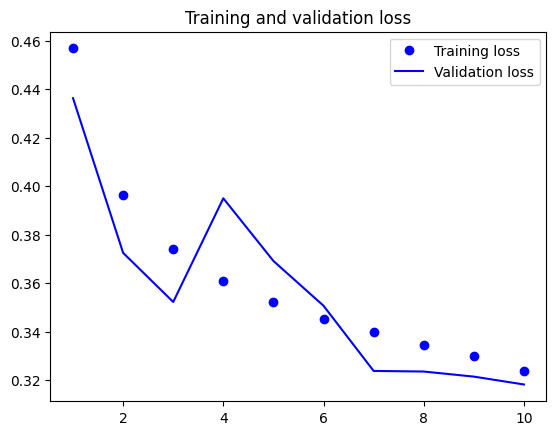

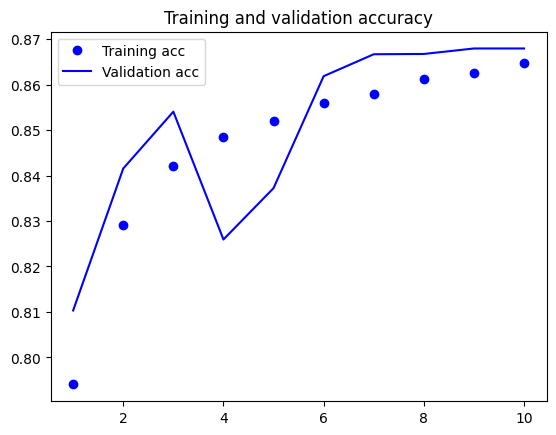

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [20]:
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

C:\Users\Professional\AppData\Local\Temp\ipykernel_9780\1855952991.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)


15758/15758 [==============================] - 90s 6ms/step


In [21]:
predictions.shape

(15758, 2)

In [22]:
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

In [24]:
df_preds = pd.DataFrame(predictions, columns=['no_idc', 'has_idc'])

df_preds.head()

,no_idc,has_idc
0,0.502519,0.497482
1,0.501947,0.498053
2,0.502533,0.497467
3,0.502768,0.497232
4,0.501934,0.498066


In [25]:
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_idc']

In [26]:
y_pred.head()

0    0.497482
1    0.498053
2    0.497467
3    0.497232
4    0.498066
Name: has_idc, dtype: float32

In [27]:
df_val.head(5)

,image_id,patient_id,target
77794,12749_idx5_x1101_y2001_class0.png,12749,0
53679,13666_idx5_x1801_y1401_class0.png,13666,0
1821,12932_idx5_x301_y1001_class0.png,12932,0
100154,12818_idx5_x1551_y1051_class1.png,12818,1
33609,12901_idx5_x601_y1501_class0.png,12901,0


In [28]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.6816570936209767

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [31]:
test_labels = test_gen.classes

In [32]:
test_labels.shape

(15758,)

In [33]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [34]:
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

Confusion matrix, without normalization
[[6526 1353]
 [ 820 7059]]


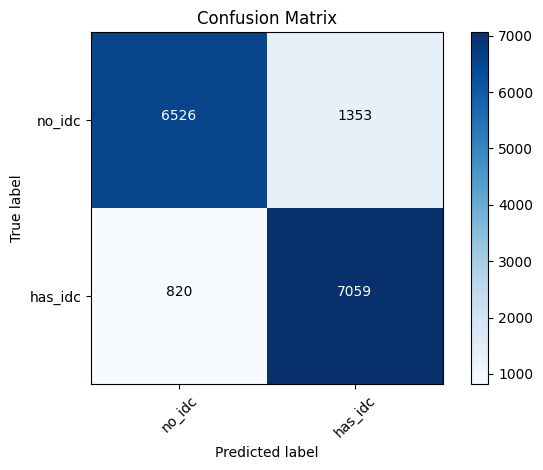

In [35]:
cm_plot_labels = ['no_idc', 'has_idc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [36]:
from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

      no_idc       0.89      0.83      0.86      7879
     has_idc       0.84      0.90      0.87      7879

    accuracy                           0.86     15758
   macro avg       0.86      0.86      0.86     15758
weighted avg       0.86      0.86      0.86     15758



In [3]:
!tensorflowjs_converter --input_format keras model.h5 tfjs_model_1/model

"tensorflowjs_converter" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


     -------------------------------------- 84.5/84.5 kB 680.9 kB/s eta 0:00:00
  Using cached tensorflowjs-4.1.0-py3-none-any.whl (84 kB)
  Using cached tensorflowjs-4.0.0-py3-none-any.whl (83 kB)
  Using cached tensorflowjs-3.21.0-py3-none-any.whl (81 kB)
  Using cached importlib_resources-5.10.2-py3-none-any.whl (34 kB)
  Using cached packaging-20.9-py2.py3-none-any.whl (40 kB)
  Using cached flax-0.6.3-py3-none-any.whl (197 kB)
  Using cached protobuf-3.19.6-cp39-cp39-win_amd64.whl (895 kB)
  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)
     ---------------------------------------- 67.0/67.0 kB 1.2 MB/s eta 0:00:00
  Using cached msgpack-1.0.4-cp39-cp39-win_amd64.whl (62 kB)
     ---------------------------------------- 6.5/6.5 MB 1.4 MB/s eta 0:00:00
     -------------------------------------- 238.1/238.1 kB 3.6 MB/s eta 0:00:00
  Using cached PyYAML-6.0-cp39-cp39-win_amd64.whl (151 kB)
  Using cached optax-0.1.4-py3-none-any.whl (154 kB)
  Using cached keras-2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-nightly-intel 2.12.0.dev20221209 requires flatbuffers>=2.0, but you have flatbuffers 1.12 which is incompatible.
tf-nightly-intel 2.12.0.dev20221209 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.0 which is incompatible.
tensorflow-intel 2.11.0 requires flatbuffers>=2.0, but you have flatbuffers 1.12 which is incompatible.
tensorflow-intel 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.9.0 which is incompatible.
tensorflow-intel 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.0 which is incompatible.
tensorflow-intel 2.11.0 requires tensorboard<2.12,>=2.11, but you have tensorboard 2.9.0 which is incompatible.
tensorflow-intel 2.11.0 requires tensorflow-estimator<2.12,>=2.11.0, but you have tensorflow-estimator 2.9.0 which is incompatible.


In [29]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)